In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
import os
import argparse
import logging
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from models import SetTransformer, DeepSet
from mixture_of_mvns import MixtureOfMVNs
from mvn_diag import MultivariateNormalDiag
from matplotlib.patches import Rectangle
from plots import draw_ellipse
import matplotlib.cm as cm

In [2]:
#Select hyperparameters
device = torch.device('cuda:'+str(args.device) if torch.cuda.is_available() else 'cpu')

net_name = 'set_transformer'
num_bench=100
B=10
N_min=600
N_max=1200
K=20

num_inds=128
dim_hidden=128

gpu='0'
lr=1e-3
run_name='trial'
num_steps=200
test_freq=200
save_freq=400
D = 2
dim_output = 2*D
save_dir = os.path.join('results', net_name, run_name)
benchfile = os.path.join('benchmark', 'mog_{:d}.pkl'.format(K))

In [ ]:
#Build mixtures generator

mvn = MultivariateNormalDiag(D)
mog = MixtureOfMVNs(mvn)
net = SetTransformer(D, K, dim_output, num_inds = num_inds, dim_hidden=dim_hidden).to(device)

In [ ]:
print(net)

In [ ]:
#Useful functions

def generate_benchmark():
    if not os.path.isdir('benchmark'):
        os.makedirs('benchmark')
    N_list = np.random.randint(N_min, N_max, num_bench)
    data = []
    ll = 0.
    for N in tqdm(N_list):
        X, labels, pi, params = mog.sample(B, N, K, return_gt=True)
        ll += mog.log_prob(X, pi, params).item()
        data.append(X)
    bench = [data, ll/num_bench]
    torch.save(bench, benchfile)

def train():
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    if not os.path.isfile(benchfile):
        generate_benchmark()

    bench = torch.load(benchfile)
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(run_name)
    logger.addHandler(logging.FileHandler(
        os.path.join(save_dir,
            'train_'+time.strftime('%Y%m%d-%H%M')+'.log'),
        mode='w'))

    optimizer = optim.Adam(net.parameters(), lr=lr)
    tick = time.time()
    for t in range(1, num_steps+1):
        if t == int(0.5*num_steps):
            optimizer.param_groups[0]['lr'] *= 0.1
        net.train()
        optimizer.zero_grad()
        N = np.random.randint(N_min, N_max)
        X = mog.sample(B, N, K)
        ll = mog.log_prob(X, *mvn.parse(net(X)))
        loss = -ll
        loss.backward()
        optimizer.step()

        if t % test_freq == 0:
            line = 'step {}, lr {:.3e}, '.format(
                    t, optimizer.param_groups[0]['lr'])
            line += test(bench, verbose=False)
            line += ' ({:.3f} secs)'.format(time.time()-tick)
            tick = time.time()
            logger.info(line)

        if t % save_freq == 0:
            torch.save({'state_dict':net.state_dict()},
                    os.path.join(save_dir, 'model.tar'))

    torch.save({'state_dict':net.state_dict()},
        os.path.join(save_dir, 'model.tar'))

def test(bench, verbose=True):
    net.eval()
    data, oracle_ll = bench
    avg_ll = 0.
    for X in data:
        X = X.to(device)
        avg_ll += mog.log_prob(X, *mvn.parse(net(X))).item()
    avg_ll /= len(data)
    line = 'test ll {:.4f} (oracle {:.4f})'.format(avg_ll, oracle_ll)
    if verbose:
        logging.basicConfig(level=logging.INFO)
        logger = logging.getLogger(run_name)
        logger.addHandler(logging.FileHandler(
            os.path.join(save_dir, 'test.log'), mode='w'))
        logger.info(line)
    return line

def plot():
    net.eval()
    X = mog.sample(B, np.random.randint(N_min, N_max), K)
    pi, params = mvn.parse(net(X))
    ll, labels = mog.log_prob(X, pi, params, return_labels=True)
    fig, axes = plt.subplots(2, B//2, figsize=(7*B//5,5))
    mog.plot(X, labels, params, axes)
    plt.show()

In [ ]:
train()

In [ ]:
ckpt = torch.load(os.path.join(save_dir, 'model.tar'))
net.load_state_dict(ckpt['state_dict'])
plot()

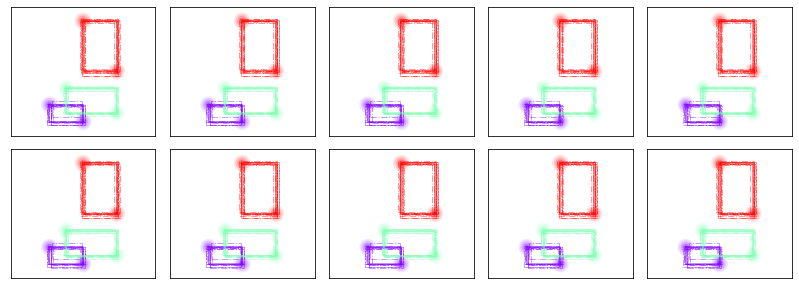

In [10]:
#Customize the plot functions to handle the four dimensional case

D = 4
mvn = MultivariateNormalDiag(D)
mog = MixtureOfMVNs(mvn)


#define base rectangles in format (coordinates upper left, coordinates bottom right)
rect1 = torch.tensor([0, 1, 2, 0])
rect2 = torch.tensor([1, 2, 4, 0.5])
rect3 = torch.tensor([2, 6, 4, 3])
rects = torch.vstack((rect1, rect2, rect3))


#augment the base rectangles with noise
cov = 0.1
rects_augm = torch.cat((rects[0,:].repeat(10, 1), 
                        rects[1,:].repeat(10, 1), 
                        rects[2,:].repeat(10, 1)), 
                       0)

rects_augm += cov*torch.randn_like(rects_augm)

labels = torch.cat((torch.tensor(0).repeat(10, 1), 
                        torch.tensor(1).repeat(10, 1), 
                        torch.tensor(2).repeat(10, 1)), 
                       0)


X = rects_augm.unsqueeze(0).repeat(10, 1, 1)
labels_X = labels.unsqueeze(0).repeat(10, 1, 1)


#Model a set transformer prediction
mu = rects.clone()
mu_X = mu.unsqueeze(0).repeat(10, 1, 1)
cov_X = torch.tensor(cov).unsqueeze(0).unsqueeze(0).repeat(10, 3, 1)

params = (mu_X, cov_X)


fig, axes = plt.subplots(2, 10//2, figsize=(7*10//5,5))
mog.plot(X, labels_X, params, axes)
